<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet on CIFAR-10 Dataset

In this assignment, we will gain some practical experience of coding a deep neural network in Tensorflow. The simplest way to code a network is to use the High level Keras API within Tensorflow 2.x.  

## (a) Introduction
For this assignment we will code a simplified ResNet network. We have discussed the principles of the ResNet architecture in detail in Lesson 3. ResNets are often an excellent choice as a baseline network for many deep learning task due to ease of training. The table below shows various ResNet structures from the original [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf). These architectures were designed to receive a 224 x 224 pixel input as they were trained on the ImageNet dataset. As we can see in the table and also saw in the Lessons, the core of the ResNet architecutures is repeating residual (conv) blocks.
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/resnet_table.JPG?raw=true) 

 In this assignment to reduce training time and computation, we will train our network using the simpler CIFAR10 dataset. As the CIFAR-10 dataset only has 32 x 32 images, we will simplify architecture of our ResNet strucutre. It will not be necessary to include the 7 x 7 convolution input and pooling layers, which agressively reduce the input size. We can also use fewer channels in each of the layers due to the less complex dataset. The details of the target architecture for this assignment are given in section (c) below. 

This Assignment is Divided into a number of steps. You will follow a standard Deep learning training methodology and complete key coding steps for the ResNet model yourself. 

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding - We will write code to build the model using the Tensorflow keras API.
  * **You will code 3 key functions in this section**
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.


## (b) Residual Blocks

As we have seen in the lessons the key building block in the ResNet architecture is the Residual block. As shown in the figure (a) below a Type A residual block consists of a main path consisting of sequential convolution, batch normalisation and ReLU activation layers. A shortcut path feeds the input to a summation node before the last activation. As we saw in the lessons the inclusion of this shortcut path, makes the overall network easier to train. 
A typical neural network design principle, seen in many image classification and object detection networks is to progressively reduce the size of the feature map dimensions while simultaneously increasing the number of channels. The same principle is applied in ResNet architectures, as can be seen in the architecture table at the top of the notebook. However it must be noted that in the Type A residual block of figure (a), it is not possible to accomodate any change the feature map dimensions or number of channels along the main path. Any attempt to do this leads to different size feature maps at the input to the summation block and the addition operation cannot be performed. 
By simply modifying the residual block, changes in feature map dimensions can be accomodated. In the Type B residual block in figure (b), it is shown how an additional convolution (and batch norm) layer is placed on the shortcut path. This allows the dimension of the shortcut path to be changed to match any changes made to the input along the main path. As shown in the figure (b) the feature map dimensions are divided by 2, this is achieved by including a stride of 2 in convolution blocks shown. Also in the figure (b), the channels in the residual block is simulataneously increased from N to M.  


![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_section3_partB-Page-15%20(3).jpg?raw=true)

## (c) Full Architecture.
Let's look at how we stack our residual blocks together to form a simplified ResNet model that we will code in this assignment. The spatial dimensions and number of channels are shown on the left. 

![ResNet](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_section3_partB-Page-15%20(4).jpg?raw=true)  

At the beginning, we have a single convolutional layer, followed by a batch normalization layer and a ReLU activation.  Then we have our Type A residual units, note that we use the Type B layer whenever we want to reduce the spatial dimensions and increase the number of channels of the output feature map. We end with an average pooling layer and a fully-connected layer (called a *dense* layer in Keras/Tensorflow) with softmax activation which gives us our 10 class predictions. 

 See https://arxiv.org/pdf/1312.4400.pdf (especially section 3.2) for more details on global average pooling.






#House Keeping

In [ ]:
from __future__ import print_function

%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

import numpy as np

To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

#1. Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

In [ ]:
batch_size = 32
H_trg =32
W_trg =32


label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# We initally load the raw training/test dataset
import tensorflow_datasets as tfds
ds,info= tfds.load("cifar10",with_info=True)

raw_train = tfds.load('cifar10', split='train[0%:90%]')
raw_val = tfds.load('cifar10', split='train[91%:100%]')
raw_test = tfds.load('cifar10', split='test')

# 2. Prepare Data

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

In [ ]:
# List of functions that we can apply to the dataset before sending to network for training
def test_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.resize(image, (H_trg,W_trg), method='bilinear')
  image = image-0.5
  label = tf.cast(label, tf.float32)
  return image,label

def train_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.resize(image, (H_trg+8,W_trg+8), method='bilinear')
  image = image-0.5
  #image = tf.image.random_crop(image, size=[H_trg, W_trg, 3]) # Random crop back to H_trgxW_trg
  #image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness 
  image=tf.cond(tf.random.uniform(()) < 0.25, lambda:  tf.image.flip_left_right(image), lambda: image) #Random mirroring (left/right)
  #image=tf.cond(tf.random.uniform(()) < 0.25, lambda:  tf.image.random_flip_up_down(image), lambda: image) #Random mirroring (up/down)
  label = tf.cast(label, tf.float32)
  return image,label

In [ ]:
def gen_tr_datasets(src_dataset):    
    # Define Datasets 
    #src_dataset = src_dataset.shuffle(num_train_examples) 
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    tr_dataset = tr_dataset.map(train_pipe)
    tr_dataset = tr_dataset.batch(batch_size) 
    return tr_dataset

def gen_val_datasets(src_dataset): 
    # Define Datasets 
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    test_dataset = test_dataset.map(test_pipe)
    test_dataset = test_dataset.batch(batch_size) 
    return test_dataset
# Generate the datasets
train_dataset = gen_tr_datasets(raw_train)
val_dataset = gen_val_datasets(raw_val)
test_dataset = gen_val_datasets(raw_test)

Plot some examples of the training dataset.

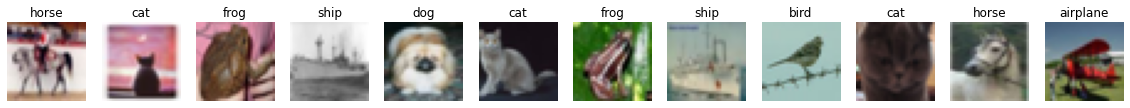

In [ ]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image, label in train_dataset.take(n_plots):  # Only take a single example
  axarr[i].imshow(image[0,:,:,:]+0.5)
  axarr[i].axis('off')
  axarr[i].title.set_text(label_str[int(label[0])])
  i = i+1



# 3 Model Coding
## Coding Part 1: Repeating unit

Within Keras there are two API's for coding network models: Sequential and functional. You may have already used the [seqential model](https://https://www.tensorflow.org/guide/keras/sequential_model) to code basic artifical neural networks. The [functional model](https://www.tensorflow.org/guide/keras/functional) is more general and enables us to include feedforward paths which are required to code the residual blocks. *Please read the explanation on the functional model, so you can successfully complete the coding assignment.* 

As the ResNet is composed of a cascade of Residual blocks, it is best to intially write code for the residual blocks before attempting to code the full architectural level of the ResNet. Within the Residual block itself, the most basic repeating unit is that of the sequence of Conv,BN,ReLU layers. Sometimes ReLU is not included and we just have Conv/BN layers.  

In the code cell below we will to create a `repeat_unit` function 

    def repeat_unit(inputs, num_filters=16, kernel_size=3,
                     strides=1, activation='relu', batch_normalization=True,
                     ):

The function needs to create a stack of Keras layers. Specifically Conv2D, BatchNormalization, and Activation:

 * The first layer needs to be a Conv2D layer using a variable number of filters, kernel size and stride;
     * You can use `same` for padding, `he_normal` for the kernel initializer, and `l2(1e-4)` for the kernel regularizer.
 * Use the boolean operator `batch_normalization` to add BatchNormalization layer after the Conv2D layer when it is True.
 * Use the string variable `activation` to add an Activation layer of the type specified (e.g. relu) after BatchNormalizationLayer, if activation is set to `None` then no activation layer is included.

 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 
 * Batch Normalization layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) 
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) 
 
 Note: We can set activation within the convolutional layer itself. However as we are using batch normalisation, we will not do that here. Instead we define the activiation layer explicitly.

In [ ]:
# Exercise: Your Code Here

def repeat_unit(inputs, num_channels=16, kernel_size=3,
                 strides=1, activation='relu', batch_normalization=True):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution. 
    x = output of repeat_unit
    """


    return x


## Coding part 2: Residual Block

We will now create a higher level `residual_block` function to create our residual blocks.
 
`def residual_block(input,num_channels,no_sc_conv):`
* This function will be able to produce either the Type A or Type B blocks shown above. 
 * It will use combinations of the repeating unit we created earlier.
  * We will also include an [addition](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) block. 
  * We will assume that along the main path of the residual block the repeating blocks have same convolutional kernel size and number of channels.
  * We need to add a final ReLU activation after the addition.
* To select between the Type A and Type B residual blocks, We will include a boolean variable (no_sc_conv) to indicate that there is no convolution in the shortcut path. 
  * If this variable is 1 then the shortcut path connects the input directly to the addition path (Type A). 
  * If this varaible is 0 then the shortcut path contains a conv path (Type B).
  * Along the shortcut path the convolution kernel size is always 1 x 1.
  * We can use this same varible to set the strides along the main path (assume Type B only required to reduces spatial dimensions by a factor of 2) 
  * The stride of the shortcut path conv must always match the stride of the 1st repeating unit (which is reponsible for reducing feature map size)
  * The number of channels along the shortcut path must match the number of channels of the convolution layers of the main channel.

In [ ]:
### Your Code here ####
def residual_block(input,num_channels,no_sc_conv=True):
  """
  input: input to residual block
  num_channels: number of channels to be used in all repeat_units
  no_sc_conv: Default = "True" => No convolution on Shortcut path 
              if set to "False" => Convolution on shortcut path
  z: Output of residual block              
  """ 
  strides = 1
  if no_sc_conv: # Select for Type A
 
  else:          # Select for Type B

  return z

## Coding part 3: Top Level

We now need to code our top level architecture as shown in the assignment introduction part B (above). 
* We will need to add a single repeating unit at the top of the stack.
* We can then add the other repeating units. These can be added individually or a for loop can be used to automatically build up the stack of residual units.
* At the end of the stack we will need to add a [global average pooling layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and fully connected [(Dense)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation. 

In [ ]:
## Your Code Here ##
def resnet_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset 
    model:       keras Model returned by this function.                          
    """
    # Variables. (Add more internal variables here if required)
    num_channels = 16   # Starting number of channels


    # Define input of model
    inputs = Input(shape=input_shape)

    # Add First repeating Unit 



    # Instantiate the stack of residual units

     

    # Add final stages. (Ensure that you call the output of the very last layer outputs)
    
    outputs = 

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics. 

Note the use here of [Sparse Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). This loss function allows us to input integer values for true classes. With the regular categorical cross entropy loss function the supplied labels must be frist converted to a one-hot representation,  but this special loss function allows us to avoid manually converting to the one-hot representation.

The completed model should have 
* Total params: 274,442
* Trainable params: 273,066
* Non-trainable params: 1,376

In [ ]:
input_shape = (32,32,3)
model = resnet_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Uncomment the following line to plot the model visually - warning, even for this simplified ResNet, it is quite large!
# keras.utils.plot_model(model, dpi=48)


# 5. Model Training

We will now train the complied model on the cifar10 dataset using the tensorflow keras `model.fit` method. 



In [ ]:
epochs =20
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

We will plot the loss and accuracy for the training and validation data sets.

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 6. Model Testing
We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch) 
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))


Create and plot a confusion matrix.

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

Generate & print the classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

Plot some test images and predicted labels.

(32, 10)
(32,)
Predictions:
 [2 8 6 9 7 1 7 0 5 2 7 2 7 9 2 8 2 8 7 9 2 5 3 5 3 8 2 8 1 8 2 0]


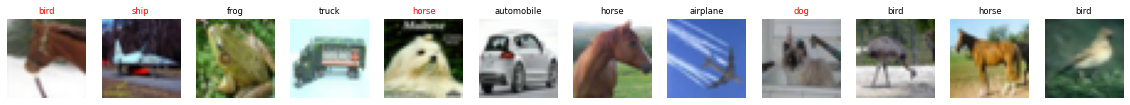

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')
  
  color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1